In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-06-22 12:10:10--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  9.62MB/s    in 42s     

2020-06-22 12:10:53 (10.1 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
!unzip -q -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [7]:
!mv Food-5K/* .

In [8]:
!ls

evaluation  Food-5K  Food-5K.zip  __MACOSX  sample_data  training  validation


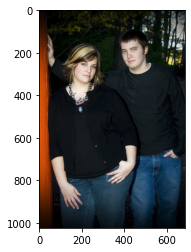

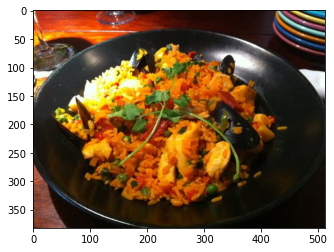

In [9]:
plt.figure(1)
plt.imshow(image.load_img('training/0_377.jpg'))
plt.show()

plt.figure(2)
plt.imshow(image.load_img('training/1_114.jpg'))
plt.show()

In [10]:
!mkdir data

In [11]:
# Making directories to use for Datagenerator

!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [12]:
# Moving the images to these directories

!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [13]:
train_path = 'data/train'
valid_path = 'data/test'

In [14]:
IMAGE_SIZE = [200, 200]

In [15]:
# Getting all file paths into a list, will be used to know no. of files

image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print('image_files', image_files)
print('valid_image_files', valid_image_files)

image_files ['data/train/nonfood/0_1086.jpg', 'data/train/nonfood/0_1323.jpg', 'data/train/nonfood/0_33.jpg', 'data/train/nonfood/0_658.jpg', 'data/train/nonfood/0_1185.jpg', 'data/train/nonfood/0_1290.jpg', 'data/train/nonfood/0_943.jpg', 'data/train/nonfood/0_1333.jpg', 'data/train/nonfood/0_1352.jpg', 'data/train/nonfood/0_776.jpg', 'data/train/nonfood/0_903.jpg', 'data/train/nonfood/0_1358.jpg', 'data/train/nonfood/0_1379.jpg', 'data/train/nonfood/0_1121.jpg', 'data/train/nonfood/0_716.jpg', 'data/train/nonfood/0_69.jpg', 'data/train/nonfood/0_543.jpg', 'data/train/nonfood/0_1088.jpg', 'data/train/nonfood/0_939.jpg', 'data/train/nonfood/0_1045.jpg', 'data/train/nonfood/0_981.jpg', 'data/train/nonfood/0_288.jpg', 'data/train/nonfood/0_1383.jpg', 'data/train/nonfood/0_1267.jpg', 'data/train/nonfood/0_1446.jpg', 'data/train/nonfood/0_470.jpg', 'data/train/nonfood/0_440.jpg', 'data/train/nonfood/0_159.jpg', 'data/train/nonfood/0_616.jpg', 'data/train/nonfood/0_727.jpg', 'data/train/non

In [16]:
# Adding folder paths into a list, useful for getting no. of classes

folders = glob(train_path + '/*')
print('folders', folders)

folders ['data/train/nonfood', 'data/train/food']


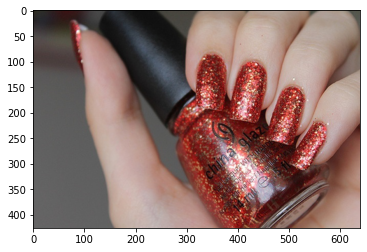

In [17]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [18]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
# Freezing pretrined model weights
ptm.trainable = False

In [20]:
# Mapping data into feature vectors
# Keras image data generator retruns classes as one hot encoded

K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [21]:
model = Model(inputs=ptm.input, outputs=x)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [23]:
# Creating an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [24]:
batch_size = 128
# Creating generators

train_generator = gen_train.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

valid_generator = gen_test.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
# Training the model
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
24/24 [==============================] - 66s 3s/step - loss: 1.7605 - accuracy: 0.9193 - val_loss: 0.6302 - val_accuracy: 0.9720
Epoch 2/10
24/24 [==============================] - 58s 2s/step - loss: 0.5907 - accuracy: 0.9760 - val_loss: 0.6188 - val_accuracy: 0.9710
Epoch 3/10
24/24 [==============================] - 57s 2s/step - loss: 0.3736 - accuracy: 0.9800 - val_loss: 0.6671 - val_accuracy: 0.9740
Epoch 4/10
24/24 [==============================] - 57s 2s/step - loss: 0.2080 - accuracy: 0.9867 - val_loss: 0.5683 - val_accuracy: 0.9770
Epoch 5/10
24/24 [==============================] - 57s 2s/step - loss: 0.1565 - accuracy: 0.9910 - val_loss: 0.5188 - val_accuracy: 0.9720
Epoch 6/10
24/24 [==============================] - 57s 2s/step - loss: 0.1209 - accuracy: 0.9900 - val_loss: 0.6688 - val_accuracy: 0.9750
Epoch 7/10
24/24 [==============================] - 56s 2s/step - loss: 0.1851 - acc

In [27]:
# Creating 2nd train generator without data augmentation to get true train accuracy

train_generator_2 = gen_test.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

model.evaluate_generator(
    train_generator_2,
    steps=int(np.ceil(len(image_files) / batch_size))
)

Found 3000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.024927688762545586, 0.9980000257492065]

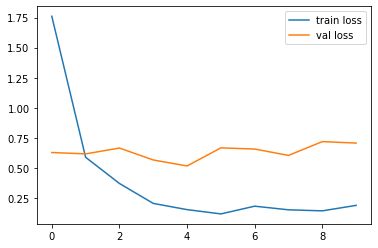

In [28]:
# Plotting loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

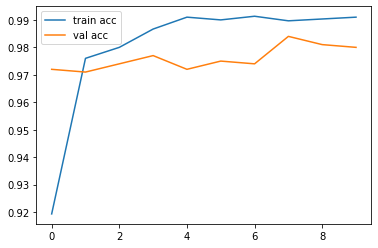

In [29]:
# Plotting accuracy

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()